<a href="https://colab.research.google.com/github/kavyaLokuge/FDL/blob/main/Final_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


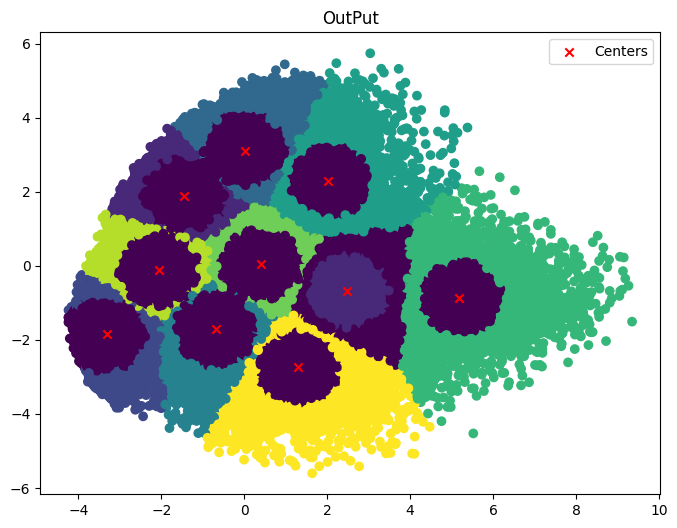

In [ ]:
# FROM MINST DATASET

import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing
from sklearn.cluster import KMeans
import phe
from phe import paillier

def calculate_pairwise_distances(X, centers):
    return np.linalg.norm(X[:, np.newaxis] - centers, axis=2)

class FuzzyCMeans:
    def __init__(self, num_clusters=5, max_iterations=100, m=2):
        self.num_clusters = num_clusters
        self.max_iterations = max_iterations
        self.m = m
        self.cluster_centers_ = None

    def fit(self, X, initial_centers, learning_rate):
        self.cluster_centers_ = initial_centers
        prev_centers = initial_centers.copy()
        fig, ax = plt.subplots(figsize=(8, 6))
        for iteration in range(1, self.max_iterations + 1):
            distances = calculate_pairwise_distances(X, self.cluster_centers_)
            membership_matrix = self.calculate_membership(distances)

            alpha = learning_rate / iteration
            self.cluster_centers_ = self.calculate_cluster_centers(X, membership_matrix, alpha)

            if np.allclose(prev_centers, self.cluster_centers_):
                print(f"Convergence achieved at iteration {iteration}")
                break

            prev_centers = self.cluster_centers_

            # Plot data points and cluster centers
            ax.clear()
            ax.scatter(X[:, 0], X[:, 1], c=np.argmax(membership_matrix, axis=1), cmap='viridis')
            ax.scatter(self.cluster_centers_[:, 0], self.cluster_centers_[:, 1], c='red', marker='x', label='Centers')
            # ax.set_title(f"Iteration {iteration}")
            ax.set_title(f"OutPut")
            ax.legend()
            plt.pause(0.5)

        plt.show()

    def calculate_membership(self, distances):
        min_distances = np.min(distances, axis=1)
        membership_matrix = np.where(distances == min_distances[:, np.newaxis], 1.0,
                                     (1 / min_distances[:, np.newaxis]) ** (2 / (self.m - 1)))
        return membership_matrix

    def calculate_cluster_centers(self, X, membership_matrix, alpha):
        numerator = np.dot(membership_matrix.T ** self.m, X)
        denominator = np.sum(membership_matrix.T ** self.m, axis=1, keepdims=True)
        cluster_centers = self.cluster_centers_ + alpha * (numerator / denominator - self.cluster_centers_)
        return cluster_centers

class FederatedLearningServer:
    def __init__(self, num_clusters, num_clients, private_key):
        self.num_clusters = num_clusters
        self.num_clients = num_clients
        self.cluster_centers_ = None
        self.private_key = private_key

    def initialize_clusters(self, X):
        kmeans = KMeans(n_clusters=self.num_clusters, init='k-means++')
        kmeans.fit(X)
        self.cluster_centers_ = kmeans.cluster_centers_

    def update_clusters(self, client_updates):
        encrypted_aggregated_centers = client_updates[0]
        for update in client_updates[1:]:
            encrypted_aggregated_centers += update
        decrypted_aggregated_centers = np.array(
            [[self.private_key.decrypt(val) for val in row] for row in encrypted_aggregated_centers])
        self.cluster_centers_ = decrypted_aggregated_centers / len(client_updates)

    def get_cluster_centers(self):
        return self.cluster_centers_

class FederatedLearningClient:
    def __init__(self, data, public_key):
        self.data = data
        self.public_key = public_key

    def compute_cluster_centers(self, server_centers, learning_rate, iteration):
        fcm = FuzzyCMeans()
        fcm.fit(self.data, server_centers, learning_rate / (iteration + 1))
        cluster_centers = fcm.cluster_centers_
        encrypted_cluster_centers = self.encrypt_data(cluster_centers)
        return encrypted_cluster_centers

    def encrypt_data(self, data):
        encrypted_data = np.array([[self.public_key.encrypt(val) for val in row] for row in data])
        return encrypted_data

def main():
    num_clusters = 10  # There are 10 digits in MNIST
    num_clients = 10
    max_iterations = 500
    m = 2
    learning_rate = 0.01

    # Load MNIST dataset
    mnist = fetch_openml('mnist_784', version=1)
    X = mnist.data / 255.0  # Normalize the data
    y = mnist.target

    # Reduce dimensionality to 2 for visualization
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    public_key, private_key = paillier.generate_paillier_keypair()

    server = FederatedLearningServer(num_clusters, num_clients, private_key)
    server.initialize_clusters(X_pca)

    clients = []
    for i in range(num_clients):
        client_data = X_pca[i * (X_pca.shape[0] // num_clients):(i + 1) * (X_pca.shape[0] // num_clients)]
        client = FederatedLearningClient(client_data, public_key)
        clients.append(client)

    num_jobs = min(num_clients, multiprocessing.cpu_count())  # Adjust the number of parallel jobs based on the available resources
    client_updates = Parallel(n_jobs=num_jobs)(delayed(client.compute_cluster_centers)(
        server.get_cluster_centers(), learning_rate, max_iterations) for client in clients)

    server.update_clusters(client_updates)

    # Plot final result
    fcm = FuzzyCMeans(num_clusters, max_iterations, m)
    fcm.cluster_centers_ = server.cluster_centers_
    fcm.fit(X_pca, fcm.cluster_centers_, learning_rate)

if __name__ == '__main__':
    main()




ORIGINAL WITH SYNTHETIC DATA

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing
from sklearn.cluster import KMeans
import phe
from phe import paillier


def calculate_pairwise_distances(X, centers):
    return np.linalg.norm(X[:, np.newaxis] - centers, axis=2)


class FuzzyCMeans:
    def __init__(self, num_clusters=5, max_iterations=100, m=2):
        self.num_clusters = num_clusters
        self.max_iterations = max_iterations
        self.m = m
        self.cluster_centers_ = None

    def fit(self, X, initial_centers, learning_rate):
        self.cluster_centers_ = initial_centers
        prev_centers = initial_centers.copy()
        fig, ax = plt.subplots(figsize=(8, 6))
        for iteration in range(1, self.max_iterations + 1):
            distances = calculate_pairwise_distances(X, self.cluster_centers_)
            membership_matrix = self.calculate_membership(distances)

            alpha = learning_rate / iteration
            self.cluster_centers_ = self.calculate_cluster_centers(X, membership_matrix, alpha)

            if np.allclose(prev_centers, self.cluster_centers_):
                print(f"Convergence achieved at iteration {iteration}")
                break

            prev_centers = self.cluster_centers_

            # Plot data points and cluster centers
            ax.clear()
            ax.scatter(X[:, 0], X[:, 1], c=np.argmax(membership_matrix, axis=1), cmap='viridis')
            ax.scatter(self.cluster_centers_[:, 0], self.cluster_centers_[:, 1], c='red', marker='x', label='Centers')
            # ax.set_title(f"Iteration {iteration}")
            ax.set_title(f"OutPut")
            ax.legend()
            plt.pause(0.5)

        plt.show()

    def calculate_membership(self, distances):
        min_distances = np.min(distances, axis=1)
        membership_matrix = np.where(distances == min_distances[:, np.newaxis], 1.0,
                                     (1 / min_distances[:, np.newaxis]) ** (2 / (self.m - 1)))
        return membership_matrix

    def calculate_cluster_centers(self, X, membership_matrix, alpha):
        numerator = np.dot(membership_matrix.T ** self.m, X)
        denominator = np.sum(membership_matrix.T ** self.m, axis=1, keepdims=True)
        cluster_centers = self.cluster_centers_ + alpha * (numerator / denominator - self.cluster_centers_)
        return cluster_centers


class FederatedLearningServer:
    def __init__(self, num_clusters, num_clients, private_key):
        self.num_clusters = num_clusters
        self.num_clients = num_clients
        self.cluster_centers_ = None
        self.private_key = private_key

    def initialize_clusters(self, X):
        kmeans = KMeans(n_clusters=self.num_clusters, init='k-means++')
        kmeans.fit(X)
        self.cluster_centers_ = kmeans.cluster_centers_

    def update_clusters(self, client_updates):
        encrypted_aggregated_centers = client_updates[0]
        for update in client_updates[1:]:
            encrypted_aggregated_centers += update
        decrypted_aggregated_centers = np.array(
            [[self.private_key.decrypt(val) for val in row] for row in encrypted_aggregated_centers])
        self.cluster_centers_ = decrypted_aggregated_centers / len(client_updates)

    def get_cluster_centers(self):
        return self.cluster_centers_


class FederatedLearningClient:
    def __init__(self, data, public_key):
        self.data = data
        self.public_key = public_key

    def compute_cluster_centers(self, server_centers, learning_rate, iteration):
        fcm = FuzzyCMeans()
        fcm.fit(self.data, server_centers, learning_rate / (iteration + 1))
        cluster_centers = fcm.cluster_centers_
        encrypted_cluster_centers = self.encrypt_data(cluster_centers)
        return encrypted_cluster_centers

    def encrypt_data(self, data):
        encrypted_data = np.array([[self.public_key.encrypt(val) for val in row] for row in data])
        return encrypted_data


def main():
    num_clusters = 5
    num_clients = 10
    max_iterations = 500
    m = 2
    learning_rate = 0.01

    X, _ = make_blobs(n_samples=1000, centers=5, n_features=2, random_state=42)

    public_key, private_key = paillier.generate_paillier_keypair()

    server = FederatedLearningServer(num_clusters, num_clients, private_key)
    server.initialize_clusters(X)

    clients = []
    for i in range(num_clients):
        client_data = X[i * (X.shape[0] // num_clients):(i + 1) * (X.shape[0] // num_clients)]
        client= FederatedLearningClient(client_data, public_key)
        clients.append(client)

    num_jobs = min(num_clients, multiprocessing.cpu_count())  # Adjust the number of parallel jobs based on the available resources
    client_updates = Parallel(n_jobs=num_jobs)(delayed(client.compute_cluster_centers)(
        server.get_cluster_centers(), learning_rate, max_iterations) for client in clients)

    server.update_clusters(client_updates)

    # Plot final result
    fcm = FuzzyCMeans(num_clusters, max_iterations, m)
    fcm.cluster_centers_ = server.cluster_centers_
    fcm.fit(X, fcm.cluster_centers_, learning_rate)

if __name__ == '__main__':
    main()

**QMNIST dataset**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


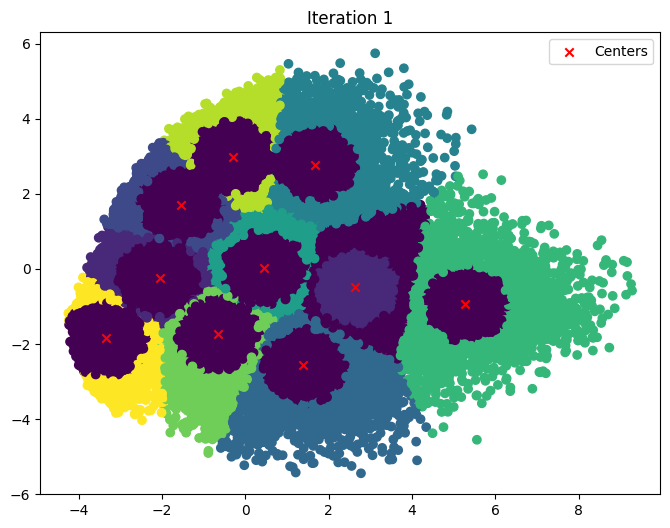

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import phe
from phe import paillier
from torchvision import datasets, transforms
import torch

def calculate_pairwise_distances(X, centers):
    return np.linalg.norm(X[:, np.newaxis] - centers, axis=2)

class FuzzyCMeans:
    def __init__(self, num_clusters=10, max_iterations=100, m=2):
        self.num_clusters = num_clusters
        self.max_iterations = max_iterations
        self.m = m
        self.cluster_centers_ = None

    def fit(self, X, initial_centers, learning_rate):
        self.cluster_centers_ = initial_centers
        prev_centers = initial_centers.copy()
        fig, ax = plt.subplots(figsize=(8, 6))
        for iteration in range(1, self.max_iterations + 1):
            distances = calculate_pairwise_distances(X, self.cluster_centers_)
            membership_matrix = self.calculate_membership(distances)

            alpha = learning_rate / iteration
            self.cluster_centers_ = self.calculate_cluster_centers(X, membership_matrix, alpha)

            if np.allclose(prev_centers, self.cluster_centers_):
                print(f"Convergence achieved at iteration {iteration}")
                break

            prev_centers = self.cluster_centers_

            # Plot data points and cluster centers
            ax.clear()
            ax.scatter(X[:, 0], X[:, 1], c=np.argmax(membership_matrix, axis=1), cmap='viridis')
            ax.scatter(self.cluster_centers_[:, 0], self.cluster_centers_[:, 1], c='red', marker='x', label='Centers')
            ax.set_title(f"Iteration {iteration}")
            ax.legend()
            plt.pause(0.5)

        plt.show()

    def calculate_membership(self, distances):
        min_distances = np.min(distances, axis=1)
        membership_matrix = np.where(distances == min_distances[:, np.newaxis], 1.0,
                                     (1 / min_distances[:, np.newaxis]) ** (2 / (self.m - 1)))
        return membership_matrix

    def calculate_cluster_centers(self, X, membership_matrix, alpha):
        numerator = np.dot(membership_matrix.T ** self.m, X)
        denominator = np.sum(membership_matrix.T ** self.m, axis=1, keepdims=True)
        cluster_centers = self.cluster_centers_ + alpha * (numerator / denominator - self.cluster_centers_)
        return cluster_centers

class FederatedLearningServer:
    def __init__(self, num_clusters, num_clients, private_key):
        self.num_clusters = num_clusters
        self.num_clients = num_clients
        self.cluster_centers_ = None
        self.private_key = private_key

    def initialize_clusters(self, X):
        kmeans = KMeans(n_clusters=self.num_clusters, init='k-means++')
        kmeans.fit(X)
        self.cluster_centers_ = kmeans.cluster_centers_

    def update_clusters(self, client_updates):
        encrypted_aggregated_centers = client_updates[0]
        for update in client_updates[1:]:
            encrypted_aggregated_centers += update
        decrypted_aggregated_centers = np.array(
            [[self.private_key.decrypt(val) for val in row] for row in encrypted_aggregated_centers])
        self.cluster_centers_ = decrypted_aggregated_centers / len(client_updates)

    def get_cluster_centers(self):
        return self.cluster_centers_

class FederatedLearningClient:
    def __init__(self, data, public_key):
        self.data = data
        self.public_key = public_key

    def compute_cluster_centers(self, server_centers, learning_rate, iteration):
        fcm = FuzzyCMeans()
        fcm.fit(self.data, server_centers, learning_rate / (iteration + 1))
        cluster_centers = fcm.cluster_centers_
        encrypted_cluster_centers = self.encrypt_data(cluster_centers)
        return encrypted_cluster_centers

    def encrypt_data(self, data):
        encrypted_data = np.array([[self.public_key.encrypt(float(val)) for val in row] for row in data])
        return encrypted_data

def main():
    num_clusters = 10  # There are 10 digits in QMNIST
    num_clients = 10
    max_iterations = 100
    m = 2
    learning_rate = 0.01

    # Load QMNIST dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    qmnist_train = datasets.QMNIST(root='./data', train=True, download=True, transform=transform)
    X = qmnist_train.data.view(-1, 28*28).float().numpy() / 255.0
    y = qmnist_train.targets.numpy()

    # Reduce dimensionality to 2 for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    public_key, private_key = paillier.generate_paillier_keypair()

    server = FederatedLearningServer(num_clusters, num_clients, private_key)
    server.initialize_clusters(X_pca)

    clients = []
    for i in range(num_clients):
        client_data = X_pca[i * (X_pca.shape[0] // num_clients):(i + 1) * (X_pca.shape[0] // num_clients)]
        client = FederatedLearningClient(client_data, public_key)
        clients.append(client)

    num_jobs = min(num_clients, multiprocessing.cpu_count())  # Adjust the number of parallel jobs based on the available resources
    client_updates = Parallel(n_jobs=num_jobs)(delayed(client.compute_cluster_centers)(
        server.get_cluster_centers(), learning_rate, max_iterations) for client in clients)

    server.update_clusters(client_updates)

    # Plot final result
    fcm = FuzzyCMeans(num_clusters, max_iterations, m)
    fcm.cluster_centers_ = server.cluster_centers_
    fcm.fit(X_pca, fcm.cluster_centers_, learning_rate)

if __name__ == '__main__':
    main()


**Wine Dataset**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


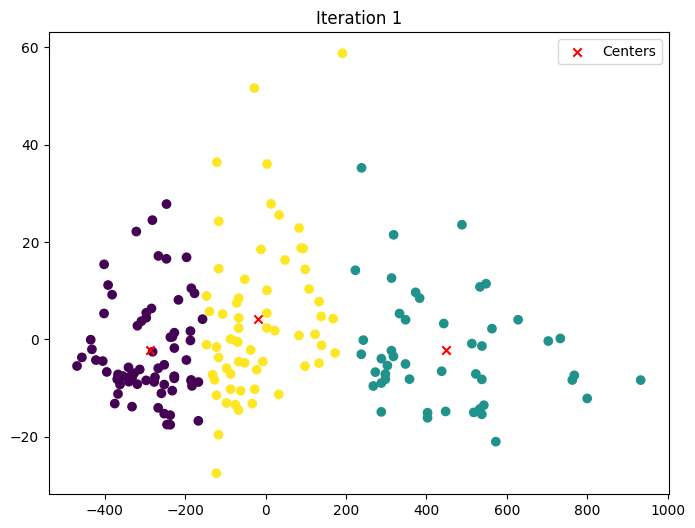

Convergence achieved at iteration 3


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.datasets import load_wine
import phe
from phe import paillier

def calculate_pairwise_distances(X, centers):
    return np.linalg.norm(X[:, np.newaxis] - centers, axis=2)

class FuzzyCMeans:
    def __init__(self, num_clusters=3, max_iterations=100, m=2):
        self.num_clusters = num_clusters
        self.max_iterations = max_iterations
        self.m = m
        self.cluster_centers_ = None

    def fit(self, X, initial_centers, learning_rate):
        self.cluster_centers_ = initial_centers
        prev_centers = initial_centers.copy()
        fig, ax = plt.subplots(figsize=(8, 6))
        for iteration in range(1, self.max_iterations + 1):
            distances = calculate_pairwise_distances(X, self.cluster_centers_)
            membership_matrix = self.calculate_membership(distances)

            alpha = learning_rate / iteration
            self.cluster_centers_ = self.calculate_cluster_centers(X, membership_matrix, alpha)

            if np.allclose(prev_centers, self.cluster_centers_):
                print(f"Convergence achieved at iteration {iteration}")
                break

            prev_centers = self.cluster_centers_

            # Plot data points and cluster centers
            ax.clear()
            ax.scatter(X[:, 0], X[:, 1], c=np.argmax(membership_matrix, axis=1), cmap='viridis')
            ax.scatter(self.cluster_centers_[:, 0], self.cluster_centers_[:, 1], c='red', marker='x', label='Centers')
            ax.set_title(f"Iteration {iteration}")
            ax.legend()
            plt.pause(0.5)

        plt.show()

    def calculate_membership(self, distances):
        min_distances = np.min(distances, axis=1)
        membership_matrix = np.where(distances == min_distances[:, np.newaxis], 1.0,
                                     (1 / min_distances[:, np.newaxis]) ** (2 / (self.m - 1)))
        return membership_matrix

    def calculate_cluster_centers(self, X, membership_matrix, alpha):
        numerator = np.dot(membership_matrix.T ** self.m, X)
        denominator = np.sum(membership_matrix.T ** self.m, axis=1, keepdims=True)
        cluster_centers = self.cluster_centers_ + alpha * (numerator / denominator - self.cluster_centers_)
        return cluster_centers

class FederatedLearningServer:
    def __init__(self, num_clusters, num_clients, private_key):
        self.num_clusters = num_clusters
        self.num_clients = num_clients
        self.cluster_centers_ = None
        self.private_key = private_key

    def initialize_clusters(self, X):
        kmeans = KMeans(n_clusters=self.num_clusters, init='k-means++')
        kmeans.fit(X)
        self.cluster_centers_ = kmeans.cluster_centers_

    def update_clusters(self, client_updates):
        encrypted_aggregated_centers = client_updates[0]
        for update in client_updates[1:]:
            encrypted_aggregated_centers += update
        decrypted_aggregated_centers = np.array(
            [[self.private_key.decrypt(val) for val in row] for row in encrypted_aggregated_centers])
        self.cluster_centers_ = decrypted_aggregated_centers / len(client_updates)

    def get_cluster_centers(self):
        return self.cluster_centers_

class FederatedLearningClient:
    def __init__(self, data, public_key):
        self.data = data
        self.public_key = public_key

    def compute_cluster_centers(self, server_centers, learning_rate, iteration):
        fcm = FuzzyCMeans()
        fcm.fit(self.data, server_centers, learning_rate / (iteration + 1))
        cluster_centers = fcm.cluster_centers_
        encrypted_cluster_centers = self.encrypt_data(cluster_centers)
        return encrypted_cluster_centers

    def encrypt_data(self, data):
        encrypted_data = np.array([[self.public_key.encrypt(val) for val in row] for row in data])
        return encrypted_data

def main():
    num_clusters = 3  # Wine dataset has 3 classes
    num_clients = 3
    max_iterations = 100
    m = 2
    learning_rate = 0.01

    # Load Wine dataset
    wine = load_wine()
    X = wine.data
    y = wine.target

    # Reduce dimensionality to 2 for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    public_key, private_key = paillier.generate_paillier_keypair()

    server = FederatedLearningServer(num_clusters, num_clients, private_key)
    server.initialize_clusters(X_pca)

    clients = []
    for i in range(num_clients):
        client_data = X_pca[i * (X_pca.shape[0] // num_clients):(i + 1) * (X_pca.shape[0] // num_clients)]
        client = FederatedLearningClient(client_data, public_key)
        clients.append(client)

    num_jobs = min(num_clients, multiprocessing.cpu_count())  # Adjust the number of parallel jobs based on the available resources
    client_updates = Parallel(n_jobs=num_jobs)(delayed(client.compute_cluster_centers)(
        server.get_cluster_centers(), learning_rate, max_iterations) for client in clients)

    server.update_clusters(client_updates)

    # Plot final result
    fcm = FuzzyCMeans(num_clusters, max_iterations, m)
    fcm.cluster_centers_ = server.cluster_centers_
    fcm.fit(X_pca, fcm.cluster_centers_, learning_rate)

if __name__ == '__main__':
    main()


minst with evaluation

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: -0.25296940485841146
Davies-Bouldin Index: 2.612718539165074


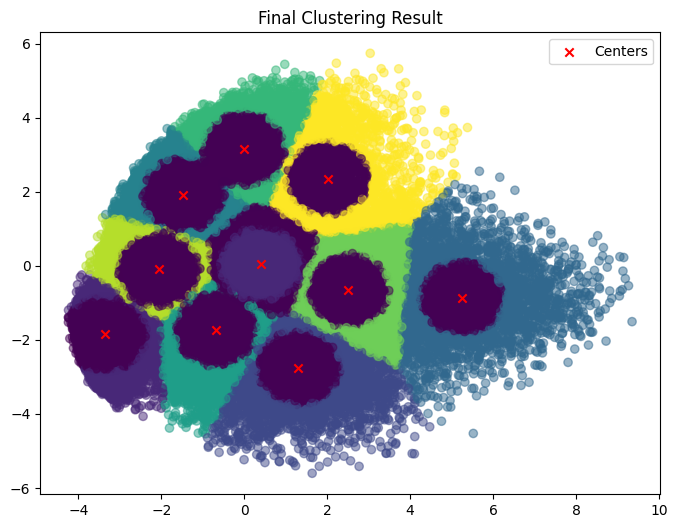

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import phe
from phe import paillier

def calculate_pairwise_distances(X, centers):
    return np.linalg.norm(X[:, np.newaxis] - centers, axis=2)

class FuzzyCMeans:
    def __init__(self, num_clusters=5, max_iterations=100, m=2):
        self.num_clusters = num_clusters
        self.max_iterations = max_iterations
        self.m = m
        self.cluster_centers_ = None

    def fit(self, X, initial_centers, learning_rate):
        self.cluster_centers_ = initial_centers
        prev_centers = initial_centers.copy()
        for iteration in range(1, self.max_iterations + 1):
            distances = calculate_pairwise_distances(X, self.cluster_centers_)
            membership_matrix = self.calculate_membership(distances)

            alpha = learning_rate / iteration
            self.cluster_centers_ = self.calculate_cluster_centers(X, membership_matrix, alpha)

            if np.allclose(prev_centers, self.cluster_centers_):
                print(f"Convergence achieved at iteration {iteration}")
                break

            prev_centers = self.cluster_centers_

        return self.cluster_centers_, membership_matrix

    def calculate_membership(self, distances):
        min_distances = np.min(distances, axis=1)
        membership_matrix = np.where(distances == min_distances[:, np.newaxis], 1.0,
                                     (1 / min_distances[:, np.newaxis]) ** (2 / (self.m - 1)))
        return membership_matrix

    def calculate_cluster_centers(self, X, membership_matrix, alpha):
        numerator = np.dot(membership_matrix.T ** self.m, X)
        denominator = np.sum(membership_matrix.T ** self.m, axis=1, keepdims=True)
        cluster_centers = self.cluster_centers_ + alpha * (numerator / denominator - self.cluster_centers_)
        return cluster_centers

class FederatedLearningServer:
    def __init__(self, num_clusters, num_clients, private_key):
        self.num_clusters = num_clusters
        self.num_clients = num_clients
        self.cluster_centers_ = None
        self.private_key = private_key

    def initialize_clusters(self, X):
        kmeans = KMeans(n_clusters=self.num_clusters, init='k-means++')
        kmeans.fit(X)
        self.cluster_centers_ = kmeans.cluster_centers_

    def update_clusters(self, client_updates):
        encrypted_aggregated_centers = client_updates[0]
        for update in client_updates[1:]:
            encrypted_aggregated_centers += update
        decrypted_aggregated_centers = np.array(
            [[self.private_key.decrypt(val) for val in row] for row in encrypted_aggregated_centers])
        self.cluster_centers_ = decrypted_aggregated_centers / len(client_updates)

    def get_cluster_centers(self):
        return self.cluster_centers_

class FederatedLearningClient:
    def __init__(self, data, public_key):
        self.data = data
        self.public_key = public_key

    def compute_cluster_centers(self, server_centers, learning_rate, iteration):
        fcm = FuzzyCMeans()
        cluster_centers, _ = fcm.fit(self.data, server_centers, learning_rate / (iteration + 1))
        encrypted_cluster_centers = self.encrypt_data(cluster_centers)
        return encrypted_cluster_centers

    def encrypt_data(self, data):
        encrypted_data = np.array([[self.public_key.encrypt(val) for val in row] for row in data])
        return encrypted_data

def evaluate_clustering(X, labels):
    silhouette = silhouette_score(X, labels)
    db_index = davies_bouldin_score(X, labels)
    print(f"Silhouette Score: {silhouette}")
    print(f"Davies-Bouldin Index: {db_index}")

def main():
    num_clusters = 10  # Number of clusters
    num_clients = 10  # Number of clients
    max_iterations = 500  # Maximum iterations for FCM
    m = 2  # Fuzziness parameter
    learning_rate = 0.01  # Learning rate

    # Load MNIST dataset locally (replace with your local path if necessary)
    try:
        mnist = fetch_openml('mnist_784', version=1)
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return

    X = mnist.data / 255.0  # Normalize the data
    y = mnist.target

    # Reduce dimensionality to 2 for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    public_key, private_key = paillier.generate_paillier_keypair()

    server = FederatedLearningServer(num_clusters, num_clients, private_key)
    server.initialize_clusters(X_pca)

    clients = []
    for i in range(num_clients):
        client_data = X_pca[i * (X_pca.shape[0] // num_clients):(i + 1) * (X_pca.shape[0] // num_clients)]
        client = FederatedLearningClient(client_data, public_key)
        clients.append(client)

    num_jobs = min(num_clients, multiprocessing.cpu_count())  # Adjust the number of parallel jobs based on the available resources
    client_updates = Parallel(n_jobs=num_jobs)(delayed(client.compute_cluster_centers)(
        server.get_cluster_centers(), learning_rate, max_iterations) for client in clients)

    server.update_clusters(client_updates)

    # Evaluate clustering
    fcm = FuzzyCMeans(num_clusters, max_iterations, m)
    fcm.cluster_centers_ = server.cluster_centers_
    labels = np.argmax(fcm.calculate_membership(calculate_pairwise_distances(X_pca, fcm.cluster_centers_)), axis=1)
    evaluate_clustering(X_pca, labels)

    # Plot final result
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.5)
    ax.scatter(fcm.cluster_centers_[:, 0], fcm.cluster_centers_[:, 1], c='red', marker='x', label='Centers')
    ax.set_title('Final Clustering Result')
    ax.legend()
    plt.show()

if __name__ == '__main__':
    main()
